# Bayesian Time Series Forecasting in Python with Orbit

How does advertising impact sales?

Make sure to install from command line: #Install dev version pip install git+https://github.com/uber/orbit.git@dev pip install git+https://github.com/uber/orbit.git@dev

Orbit quick start guide: https://uber.github.io/orbit/tutorials/quick_start.html

# Load packages and import data

In [2]:
#import pandas and numpy
import pandas as pd
import numpy as np

# From matplotlib, import pyplot under the alias plt
import matplotlib.pyplot as plt

# Reading an excel file using Python
import os

#%matplotlib inline
import orbit
from orbit.models import LGT, DLT

from orbit.diagnostics.plot import plot_predicted_data,plot_predicted_components
from orbit.eda import eda_plot



#from orbit.models.lgt import LGTMAP, LGTAggregated
#from orbit.models.dlt import DLTMAP
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter



import warnings
warnings.filterwarnings('ignore')


In [3]:
# Give the location of your file -
file = ('datasets/addata.xlsx')
 
#Load spreadsheet
data = pd.ExcelFile(file)

## Load a sheet into a DataFrame by name
df = data.parse('diet')

#Check results
print(df.head())

   Month  Sales  Advertising
0      1   12.0           15
1      2   20.5           16
2      3   21.0           18
3      4   15.5           27
4      5   15.3           21


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        36 non-null     int64  
 1   Sales        36 non-null     float64
 2   Advertising  36 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 992.0 bytes
None


In [5]:
from datetime import datetime
#Create date sequence of 36 months so we have a proper time object as our index
Date = pd.date_range('2011-01-01', periods=36, freq = 'MS')

print(Date)

#Add date sequence I just created to to dataframe
df['Date'] = Date

#Check results
print(df['Date'].head())

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01'],
              dtype='datetime64[ns]', freq='MS')
0   2011-01-01
1   2011-02-01
2   2011-03-01
3   2011-04-01
4   2011-05-01
Name: Date, dtype: datetime64[ns]


# Exploratory Data Analysis

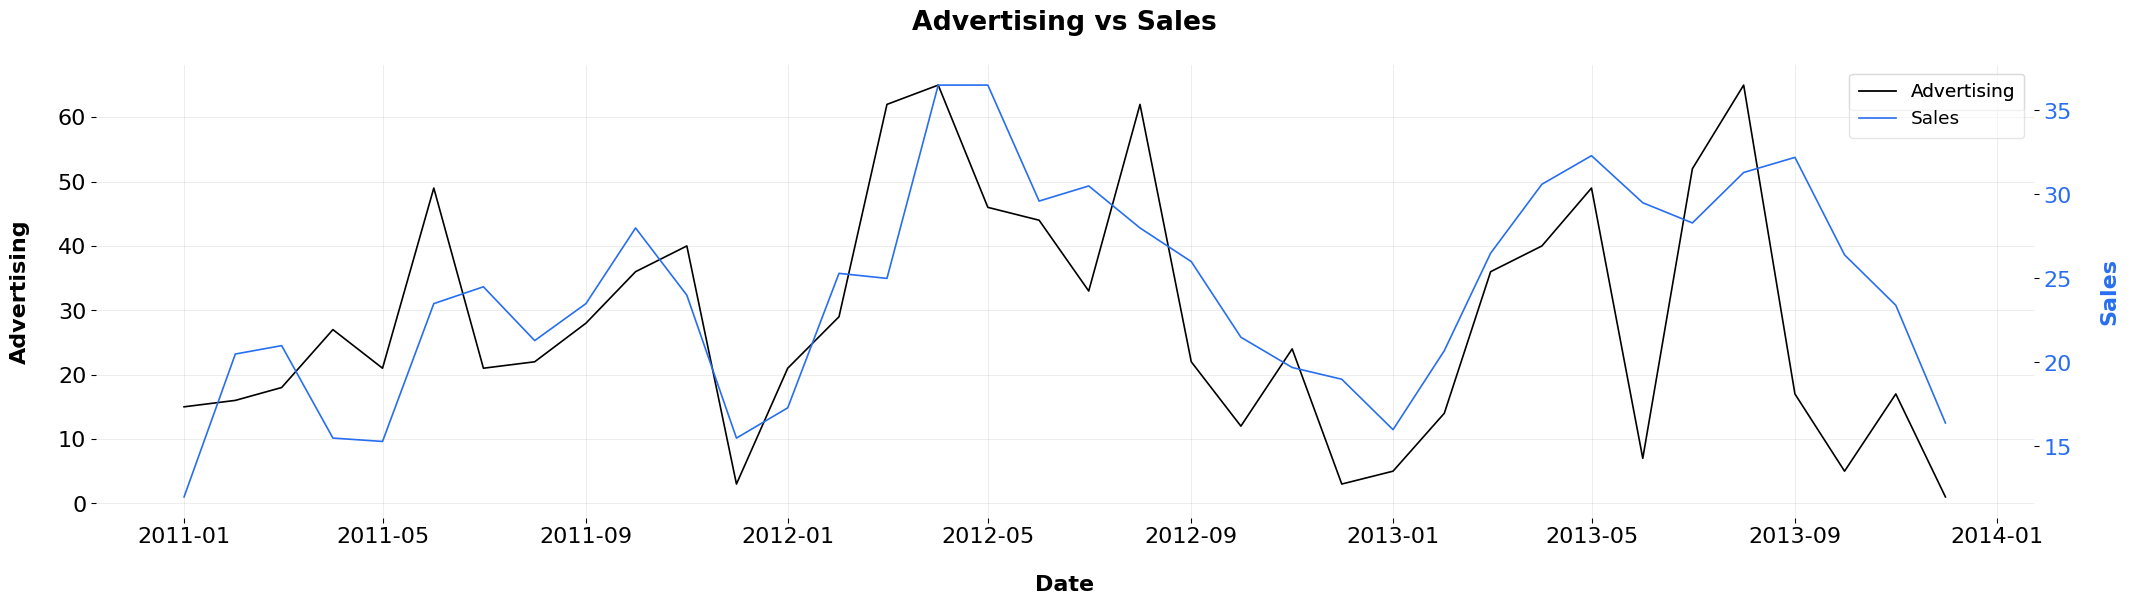

In [6]:
#Line plot of sales and advertising
_ = eda_plot.dual_axis_ts_plot(df=df, var1='Advertising', var2='Sales', date_col='Date')

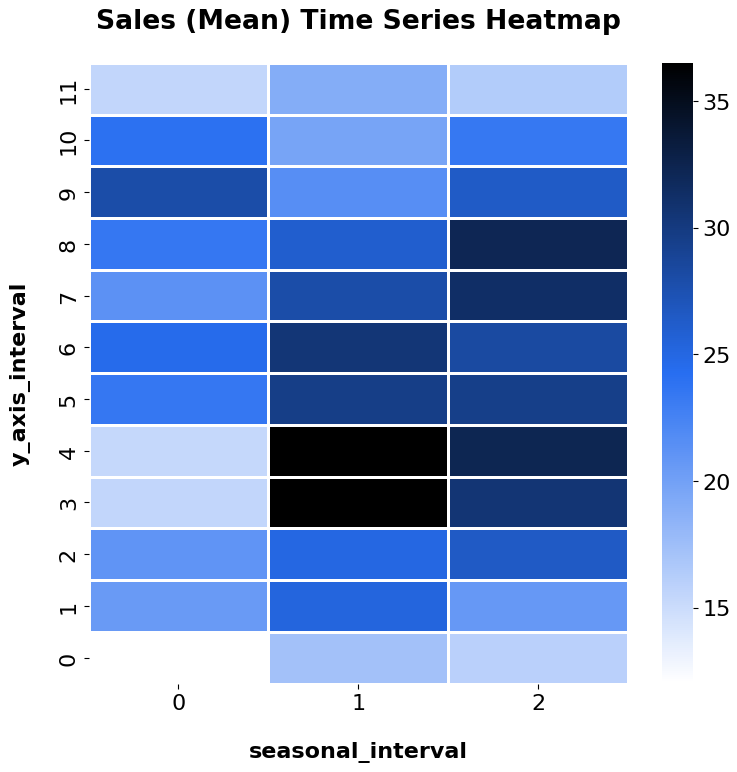

In [7]:
#Print edaplot as a heatmap
_ = eda_plot.ts_heatmap(df = df, date_col = 'Date', seasonal_interval=12, value_col='Sales')


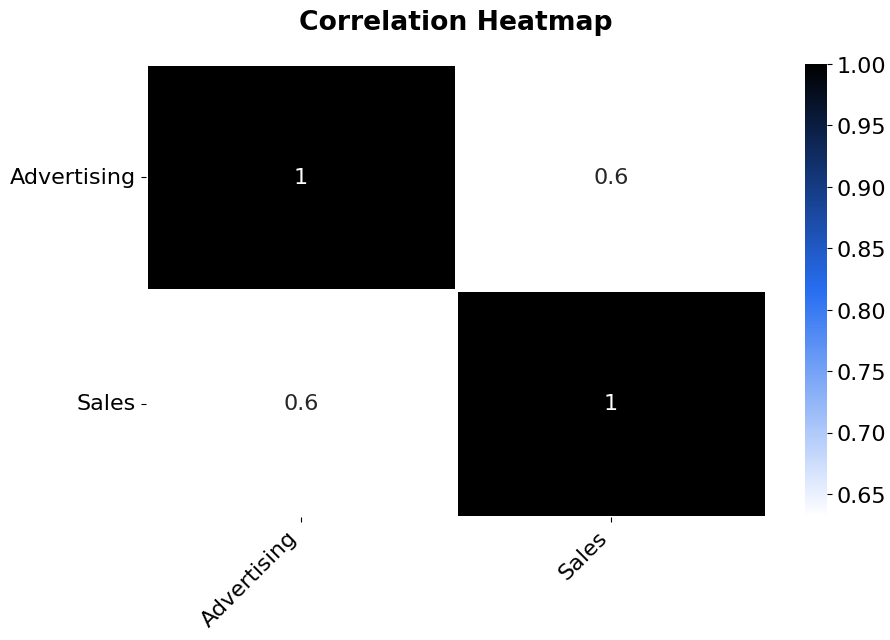

In [8]:
#Correlation plot
#Is there a correlation between advertising and sales? At .60 there is a positive relationship.
var_list = ["Date","Advertising", "Sales"]
_ = eda_plot.correlation_heatmap(df, var_list = var_list, 
                                 fig_width=10, fig_height=6)

# Test Train Split

In [9]:
import random

random.seed(10)

# train-test split
test_size = 12 # 12 months of data for test set
train_df = df[:-test_size]
test_df = df[-test_size:]

#Check results
print(train_df.tail())

    Month  Sales  Advertising       Date
19     20   28.0           62 2012-08-01
20     21   26.0           22 2012-09-01
21     22   21.5           12 2012-10-01
22     23   19.7           24 2012-11-01
23     24   19.0            3 2012-12-01


# Model Fit

In [10]:
#Fit forecast model
dlt = DLT(
  response_col='Sales', date_col='Date',
    regressor_col=['Advertising'],
    seasonality=12,
)

dlt.fit(df=train_df)

INFO:orbit:Sampling(PyStan) with chains:4, cores:4, temperature:1.0, warmups(per chain):225 and samples(per chain):25.


In [11]:
# outcomes data frame
predicted_df = dlt.predict(df=test_df, decompose=True)

print(predicted_df.head())

        Date  prediction_5  prediction  prediction_95    trend_5      trend  \
0 2013-01-01     10.137917   18.485116      27.757204  10.946361  18.374129   
1 2013-02-01     14.941961   22.946109      32.754869  11.109377  19.079629   
2 2013-03-01     13.412631   25.838815      39.229586   8.082991  20.130886   
3 2013-04-01     12.855323   27.810644      40.507318   7.237454  19.761448   
4 2013-05-01     11.481218   29.302691      44.066037   4.738494  19.606342   

    trend_95  seasonality_5  seasonality  seasonality_95  regression_5  \
0  26.817792      -2.409761    -0.737273        0.463298      0.312567   
1  28.047909      -0.196004     1.869433        4.118115      0.875189   
2  32.712967      -0.985209     0.119386        1.104857      2.250486   
3  32.669639      -0.551398     0.843380        4.677708      2.500540   
4  34.023412      -0.340129     0.951948        4.546002      3.063161   

   regression  regression_95  
0    0.832370       1.345070  
1    2.330637     

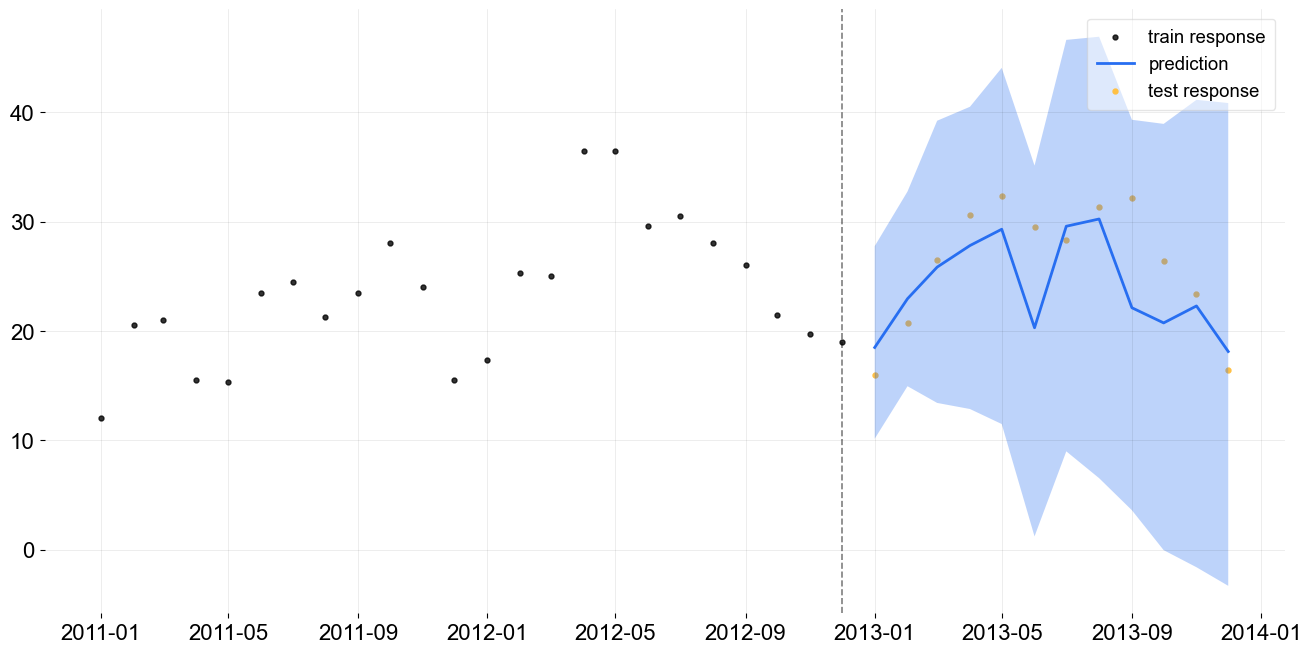

<AxesSubplot:>

In [12]:
#Plot the predicted data
from orbit.diagnostics.plot import plot_predicted_data
plot_predicted_data(
  training_actual_df=train_df, predicted_df=predicted_df,
  date_col=dlt.date_col, actual_col=dlt.response_col,
  test_actual_df=test_df
)

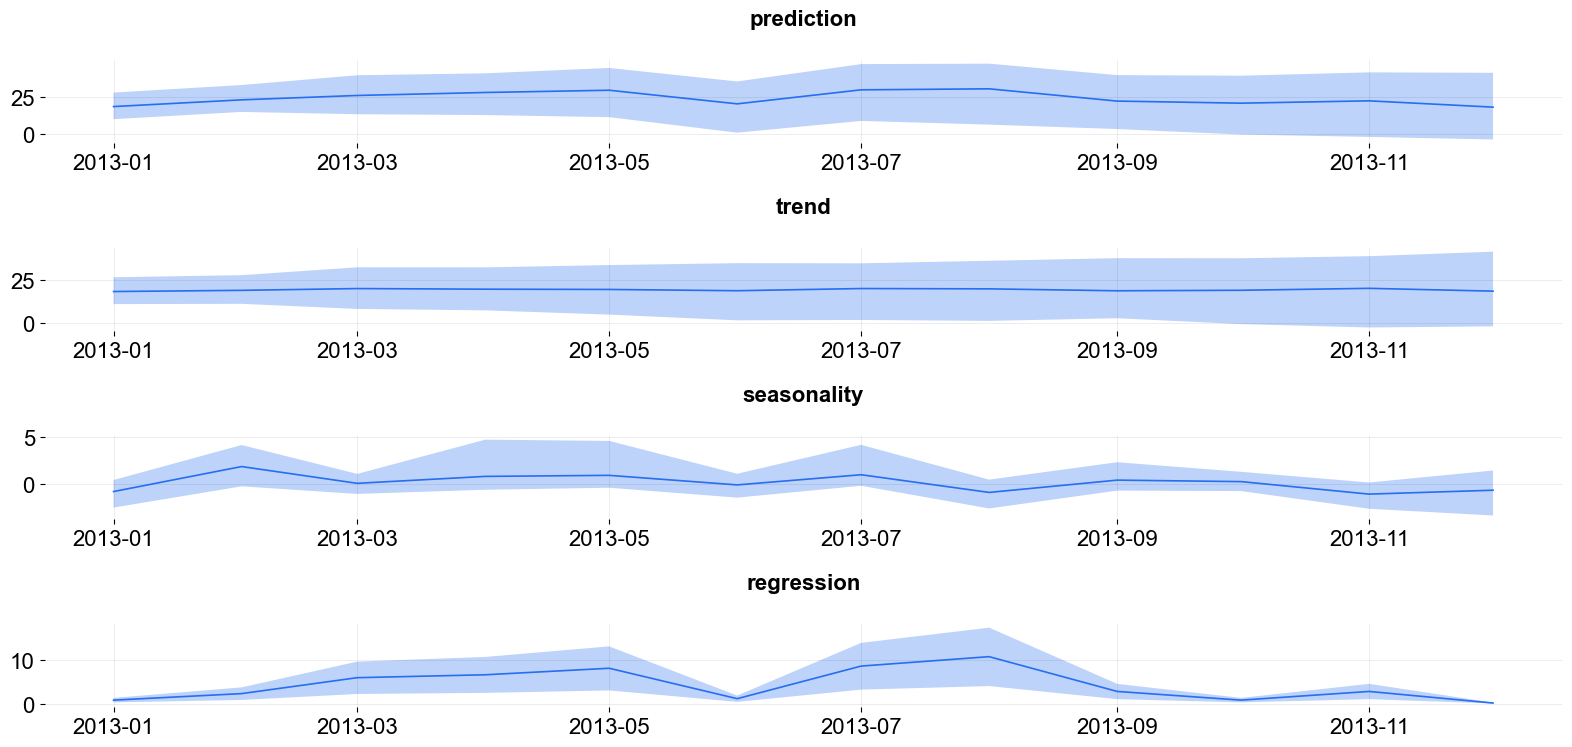

In [14]:
_ = plot_predicted_components(predicted_df, date_col='Date',
                              plot_components=['prediction', 'trend', 'seasonality', 'regression'])

In [15]:
dlt.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,Advertising,Regular,0.166474


## Model Diagnostics

https://orbit-ml.readthedocs.io/en/stable/tutorials/model_diagnostics.html

In [20]:
from orbit.models.dlt import DLTMAP
#from orbit.models.dlt import ETSFull, DLTMAP, DLTFull
# instantiate a model
dlt = DLTMAP(
    date_col='Date',
    response_col='Sales',
    regressor_col=['Advertising'],
    seasonality=12,
)

ImportError: cannot import name 'DLTMAP' from 'orbit.models.dlt' (/opt/anaconda3/lib/python3.9/site-packages/orbit/models/dlt.py)

In [21]:
# configs
min_train_len = 100
forecast_len = 20
incremental_len = 100
window_type = 'expanding'

bt = BackTester(
    model=dlt,
    df=df,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

BacktestException: required time span is more than the full data frame...

In [ ]:
bt.score(include_training_metrics=True)

In [ ]:
def mse_naive(test_actual):
    actual = test_actual[1:]
    predicted = test_actual[:-1]
    return np.mean(np.square(actual - predicted))

def naive_error(train_actual, test_predicted):
    train_mean = np.mean(train_actual)
    return np.mean(np.abs(test_predicted - train_mean))